**Run the demo.** Run the following cells to compute semantic correspondences for real image pairs.

In [1]:
%load_ext autoreload
%autoreload 2
import importlib

import os
import gc
import random
import torch

import einops
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import json
import torchvision

from extract_hyperfeatures import load_models

import archs.correspondence_utils
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# Memory requirement is 13731MiB
device = "cuda"
config_path = "configs/real.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path, device)

def clear_cuda():
    torch.cuda.empty_cache()
    gc.collect()

c:\Users\Q613871\Desktop\Code\diffusion_hyperfeatures\Diffusion_Hyperfeatures\Lib\site-packages\diffusers\pipelines\pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1-base via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


In [8]:
def process_image(image_pil, res=None, range=(-1, 1)):
    if res:
        image_pil = image_pil.resize(res, Image.BILINEAR)
    image = torchvision.transforms.ToTensor()(image_pil) # range [0, 1]
    r_min, r_max = range[0], range[1]
    image = image * (r_max - r_min) + r_min # range [r_min, r_max]
    return image[None, ...], image_pil

def flatten_feats(feats):
    b, c, w, h = feats.shape
    feats = feats.view((b, c, -1))
    feats = feats.permute((0, 2, 1))
    return feats

def normalize_feats(feats):
    feats = feats / torch.linalg.norm(feats, dim=-1, keepdim=True)
    return feats

def points_to_idxs(points, load_size):
    if not isinstance(points, np.ndarray):
        points = np.array(points)

    points_y = points[:, 0]
    points_y = np.clip(points_y, 0, load_size[1] - 1)
    points_x = points[:, 1]
    points_x = np.clip(points_x, 0, load_size[0] - 1)
    idx = load_size[1] * np.round(points_y) + np.round(points_x)
    return idx.astype(np.int64)

def load_and_compute_hyperfeats(image_path, device, load_size):
    img = Image.open(image_path).convert("RGB")
    proc_img, img_pil = process_image(img, res=load_size)
    proc_img = proc_img.to(device)

    with torch.inference_mode():
        with torch.autocast("cuda"):
            feats, _ = diffusion_extractor.forward(proc_img)
            b, s, l, w, h = feats.shape
            hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
            return hyperfeats

## Hyperfeatures for Similarities within an image for semantic correspondence

Flattened hyperfeats shape: torch.Size([1, 65536, 384]), point index: 23190


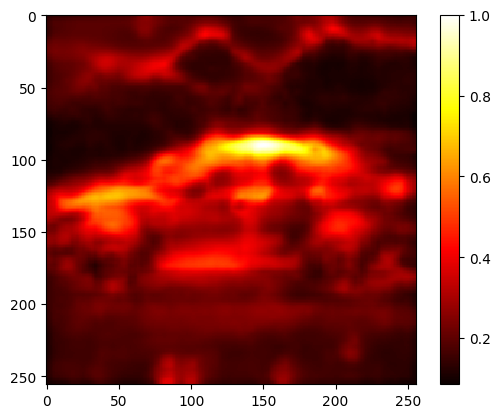

In [18]:
def calculate_similarity(hyperfeats, point, load_size):
    point_idx = points_to_idxs(np.array([point]), load_size)[0]
    hyperfeats = torch.nn.functional.interpolate(hyperfeats, size=load_size, mode="bilinear", align_corners=False)
    flattened_hyperfeats = flatten_feats(hyperfeats)
    normalized_hyperfeats = normalize_feats(flattened_hyperfeats)

    print(f"Flattened hyperfeats shape: {normalized_hyperfeats.shape}, point index: {point_idx}")
    point_hyperfeats = normalized_hyperfeats[:, point_idx, :]

    # Normalize hyperfeatures
    similarity = torch.matmul(normalized_hyperfeats, point_hyperfeats.permute(1, 0))
    return similarity

def generate_heatmap(similarity, load_size):
    similarity = similarity.view(load_size).cpu().numpy()
    plt.imshow(similarity, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

image_path = '3er_256.png'

point_bike = [175,52]
point_car = [90, 150]
load_size = (256, 256)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hyperfeats = load_and_compute_hyperfeats(image_path, device, load_size)
similarity = calculate_similarity(hyperfeats, point_car, load_size)
generate_heatmap(similarity, load_size)